**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Purpose:** To create a multiclass classification model using a custom convolutional neural network in tensorflow.

**Data Summary:** The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases. The dataset contains 9 sub-directories in each train and test set. The 9 sub-directories contains the images of 9 skin cancer types respectively.

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Importing all the important libraries

In [60]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

### Importing Skin Cancer Data

The dataset comprises of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [61]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(r"C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")


In [62]:
#Image count in train and test dataset folder

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

In [63]:
# Define some parameters for the loader:

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [64]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [65]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [66]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [67]:
for images, labels in train_ds.take(1):
    print(len(images))
    print(len(labels))

32
32


### Visualize the data:
Create a code to visualize one instance of all the nine classes present in the dataset.

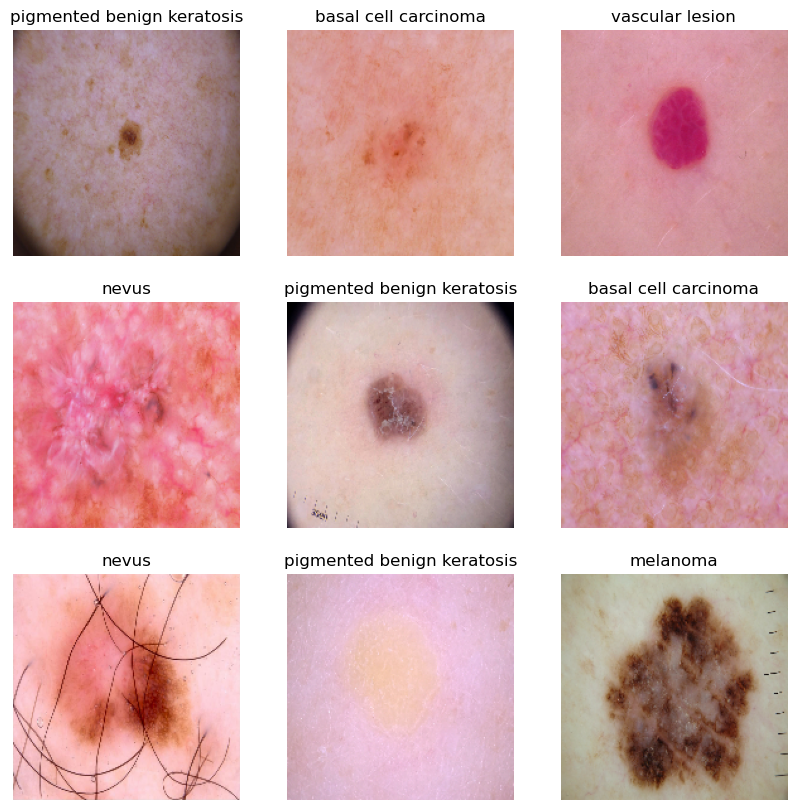

In [68]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods we should use when loading data:

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training. Speed up training

In [69]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general the input values should be smaller. We will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [70]:
normalization_layer = layers.Rescaling(1./255, input_shape=(180, 180, 3))

There are two ways to use this layer. 1st - Apply the layer to the dataset by calling Dataset.map:

In [71]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13660021 0.81748384


2nd - Include the layer inside the model definition. This simplifies deployment. 

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [72]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
num_classes = len(class_names)

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one 
#output tensor

model = Sequential()

model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))

model.add(Dense(num_classes, name="outputs"))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [73]:
#Coose an appropirate optimiser and loss function
#loss_fn = "binary_crossentropy"

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
# View the summary of all layers
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081,961 (7.94 MB)

 Trainable params: 2,081,577 (7.94 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [75]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\kalla\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.3041 - loss: 3.8312 - val_accuracy: 0.0425 - val_loss: 3.1908
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.4580 - loss: 1.6288 - val_accuracy: 0.0649 - val_loss: 7.2503
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.5031 - loss: 1.4354 - val_accuracy: 0.0559 - val_loss: 10.9219
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.5587 - loss: 1.2790 - val_accuracy: 0.0582 - val_loss: 9.6413
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.5567 - loss: 1.2520 - val_accuracy: 0.0783 - val_loss: 13.4494
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 318ms/step - accuracy: 0.5637 - loss: 1.2221 - val_accuracy: 0.2707 - val_loss: 6.6875
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.6055 - loss: 1.1295 - val_accuracy: 0.1767 - val_loss: 6.3684
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.6285 - loss: 1.0284 - val_accuracy: 0.4

### Visualizing training results

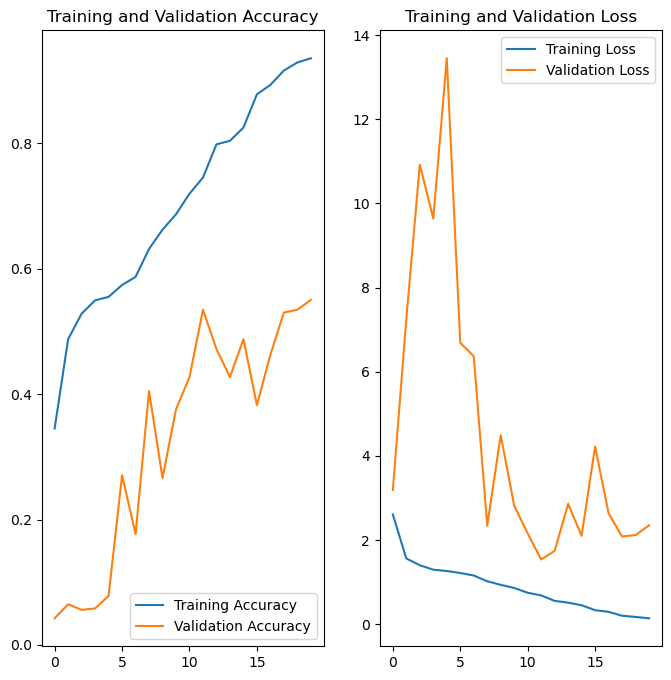

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**Inference:** The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 55% accuracy on the validation set.

In [77]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Training Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8403 - loss: 0.4070
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5676 - loss: 2.2313
Training Accuracy:  0.8381696343421936
Validation Accuracy:  0.5503355860710144
Training Loss:  0.40069082379341125
Validation Loss 2.3494820594787598


**Inference:** Thus we can clearly see that model overfits and we need to chose right data augumentation strategy

### Data Augmentation Strategy

In [78]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# Implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, 
# tf.keras.layers.RandomRotation,tf.keras.layers.RandomZoom, tf.keras.layers.RandomTranslation & tf.keras.layers.RandomCrop.
# These can be included inside our model like other layers,

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
  ]
)

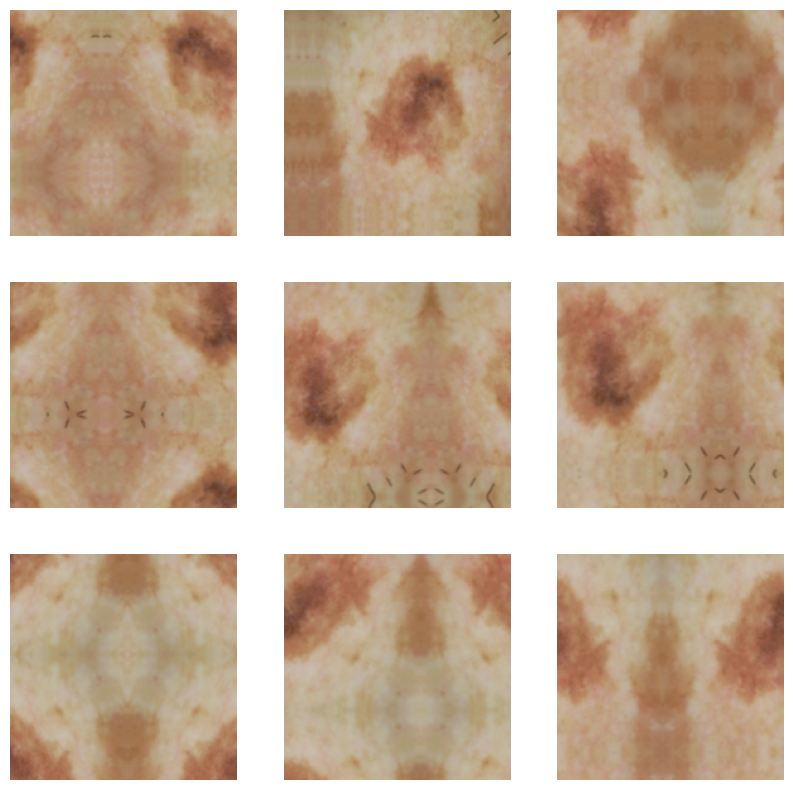

In [79]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Visualize a few augmented examples by applying data augmentation to the same image several times

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model
Apply Data Augmentation & Dropout to layers for model training


In [80]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
# Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

model = Sequential([
  data_augmentation,
    
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
  layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Dropout(0.1),
    
  layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Dropout(0.2),
    
  layers.Flatten(),
    
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])


In [82]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [84]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_13 (Rescaling)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [86]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1887 - loss: 2.2990 - val_accuracy: 0.2685 - val_loss: 1.9654
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3167 - loss: 1.8772 - val_accuracy: 0.3669 - val_loss: 1.6802
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3205 - loss: 1.7450 - val_accuracy: 0.3602 - val_loss: 1.6441
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.3543 - loss: 1.6809 - val_accuracy: 0.3803 - val_loss: 1.6386
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.3720 - loss: 1.6507 - val_accuracy: 0.3758 - val_loss: 1.6097
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.3704 - loss: 1.6484 - val_accuracy: 0.4183 - val_loss: 1.5790
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3950 - loss: 1.6034 - val_accuracy: 0.3758 - val_loss: 1.6556
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.4017 - loss: 1.5912 - val_accuracy: 0.4116 - va

### Visualizing the results

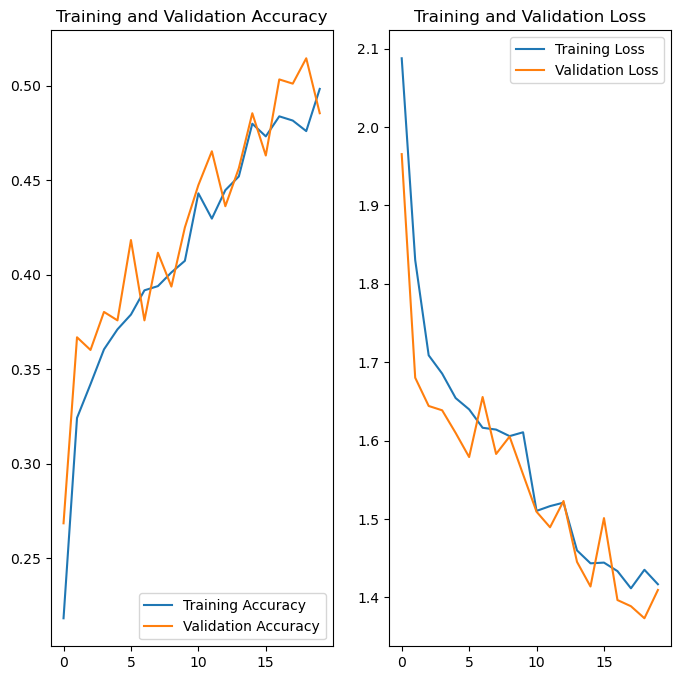

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [88]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Training Loss: ",loss)
print("Validation Loss", loss_v)


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 537ms/step - accuracy: 0.5102 - loss: 1.3465
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 543ms/step - accuracy: 0.5113 - loss: 1.3607
Training Accuracy:  0.5044642686843872
Validation Accuracy:  0.4854586124420166
Training Loss:  1.3466815948486328
Validation Loss 1.409432291984558


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Inference:** 
- After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closely aligned.
<br>
- So the overfitting is fairly controlled after using data augumentation and incorporating dropout in the model.
<br>
- However the accuracy is still around 50%, which need to be further improved.

### Find the distribution of classes in the Training Dataset to check Class Imbalance
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [89]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [90]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,actinic keratosis
1,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,actinic keratosis
2,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,actinic keratosis
3,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,actinic keratosis
4,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,actinic keratosis
...,...,...
2234,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,vascular lesion
2235,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,vascular lesion
2236,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,vascular lesion
2237,C:\Users\kalla\OneDrive\Documents\ANALYTICS\Up...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


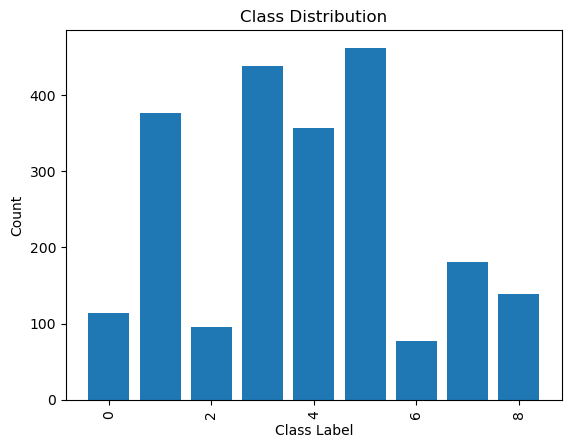

In [92]:
from sklearn.preprocessing import LabelEncoder

from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=90)  # Rotate class labels for better readability
plt.show()

<Figure size 1000x1000 with 0 Axes>

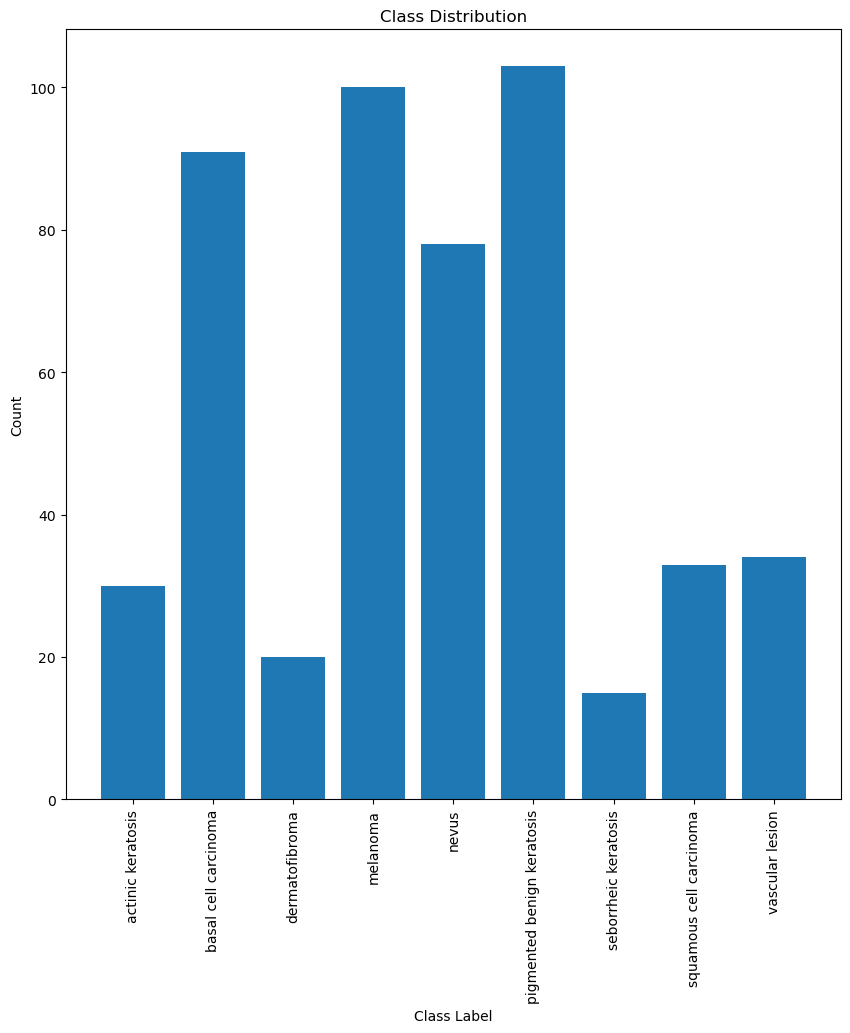

In [95]:
#Using a differnt code to display the bame of the classes

import matplotlib.pyplot as plt
data = dict()

for i in class_names:
      data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
      for i in range(9):
        data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
      data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=90)  # Rotate class labels for better readability
plt.show()

#### **Todo:** Write your findings here: 
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?


**Inference:** 
- The data is clearly imbalanced across different classes
- "Pigmented benign keratosis" has the highest proportion of samples
- Seborrheic keratosis has the lowest number of samples
- Comparitively melanoma, nevus and basal cell carcinoma has higher number of samples than other classes

### Rectify the Class Imbalance
We use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [100]:
path_to_training_dataset= r"C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\"

#path_to_training_dataset="/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17A35722A90>: 100%|█| 500/500 [00:07<00:


Initialised with 376 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17A335164D0>: 100%|█| 500/500 [00:07<00:00, 63.56 Samples/


Initialised with 95 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17A37CFF110>: 100%|█| 500/500 [00:04<00:00, 117.48 Samples


Initialised with 438 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17AC2E44090>: 100%|█| 500/500 [00:38<00:00, 12.87 Samples


Initialised with 357 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x17A334A72D0>: 100%|█| 500/500 [00:43<00:00, 11.59 Samples/


Initialised with 462 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x179AC3AAF50>: 100%|█| 500/500 [00:08<00:00, 59.68 Samples/


Initialised with 77 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x179EC091950>: 100%|█| 500/500 [00:20<00:00, 24.74 Samples


Initialised with 181 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x179AC41CBD0>: 100%|█| 500/500 [00:09<00:00, 53.37 Samples/


Initialised with 139 image(s) found.
Output directory set to C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17AC2E45050>: 100%|█| 500/500 [00:07<00:00, 64.81 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [101]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Review the distribution of augmented data after adding new images to the original training data.

In [102]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['C:\\Users\\kalla\\OneDrive\\Documents\\ANALYTICS\\UpGrad\\Course 7_Deep Learning\\Module 3_Convolutional Neural Networks\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_11f388bf-9c8e-495a-a8a4-4ba9631d180e.jpg',
 'C:\\Users\\kalla\\OneDrive\\Documents\\ANALYTICS\\UpGrad\\Course 7_Deep Learning\\Module 3_Convolutional Neural Networks\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2c54804c-3ca6-408c-9ae9-d50fae8c09a9.jpg',
 'C:\\Users\\kalla\\OneDrive\\Documents\\ANALYTICS\\UpGrad\\Course 7_Deep Learning\\Module 3_Convolutional Neural Networks\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_04247c90-50c1-4512-8961-f211eec859ed.jpg',
 'C:\\Users\\kalla\\OneDrive

In [103]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [104]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [105]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2])

In [106]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

**Inference:** So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [107]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [108]:
#data_dir_train="path to directory with training data + data created using augmentor"


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [109]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create the model (make sure to include normalization)

In [110]:
## your code goes here

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


model = Sequential([
    
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
  layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Dropout(0.1),
    
  layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
    
  layers.Dropout(0.2),
    
  layers.Flatten(),
    
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])

C:\Users\kalla\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\kalla\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### Compile the model (Choose optimizer and loss function appropriately)

In [111]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [112]:
# View the summary of all layers
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081,961 (7.94 MB)

 Trainable params: 2,081,577 (7.94 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [113]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size = batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\kalla\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 317ms/step - accuracy: 0.3008 - loss: 3.2251 - val_accuracy: 0.1648 - val_loss: 9.1840
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.4664 - loss: 1.4320 - val_accuracy: 0.1433 - val_loss: 6.2783
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 293ms/step - accuracy: 0.5376 - loss: 1.1992 - val_accuracy: 0.3727 - val_loss: 2.4697
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.6022 - loss: 1.0692 - val_accuracy: 0.4536 - val_loss: 1.6455
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 292ms/step - accuracy: 0.6551 - loss: 0.8996 - val_accuracy: 0.4633 - val_loss: 1.9137
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 289ms/step - accuracy: 0.7142 - loss: 0.7602 - val_accuracy: 0.5813 - val_loss: 1.0861
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 346ms/step - accuracy: 0.7778 - loss: 0.6011 - val_accuracy: 0.6756 - val_loss: 0.9002
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 321ms/step - accuracy: 0.8220 - loss: 0.4874 - val

### Visualize the model results

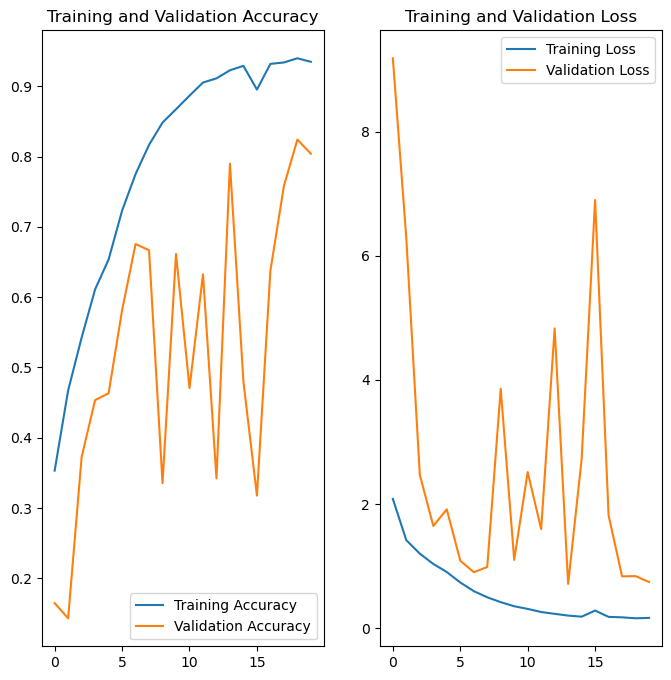

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [115]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Training Loss: ",loss)
print("Validation Loss", loss_v)


169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9169 - loss: 0.2146
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8185 - loss: 0.6997
Training Accuracy:  0.9163575768470764
Validation Accuracy:  0.8040089011192322
Training Loss:  0.2103918343782425
Validation Loss 0.7418163418769836


### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Inference:** 
- The class rebalance helped in reducing overfititng of the data and thus the loss is beng reduced. Training accuracy and validation accuracy is closely aligned now.
<br>
- Before class rebalancing, we introduced Dropout and Image Augmentation which reduced the over fit to a great extent.But the validation accuracy was not improved.
<br>
- At last we tried balancing the class imbalance using Augmentor which  helped marginally in bringing the validation accuracy closer to training accuracy. But the overall model accuracy increased to a great extent.

### Predict on Test Dataset
Use the model to classify an image that wasn't included in the training or validation sets.
<br>
Note: Data augmentation and dropout layers are inactive at inference time.

C:\Users\kalla\OneDrive\Documents\ANALYTICS\UpGrad\Course 7_Deep Learning\Module 3_Convolutional Neural Networks\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\basal cell carcinoma\*
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Actual class: basal cell carcinoma
Predicted class: basal cell carcinoma
This image most likely belongs to basal cell carcinoma with a 25.36 percent confidence.


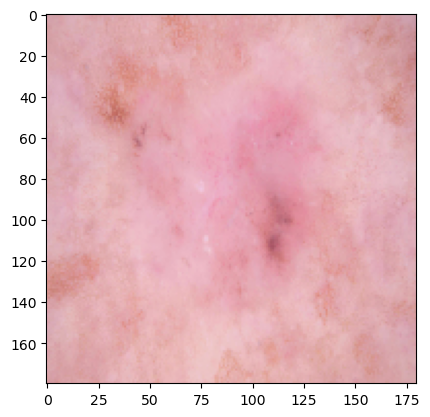

In [128]:
# Below code picks up one image at a time based upon specification using "Test_image[-2]"" and then predict only 
#one image
from glob import glob

Test_image_path=os.path.join(data_dir_test, class_names[1], '*')
print(Test_image_path)
Test_image=glob(Test_image_path)
Test_image=tf.keras.utils.load_img(Test_image[-2], target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img=np.expand_dims(Test_image, axis=0)
pred = model.predict(img)
score = tf.nn.softmax(pred[0])

pred=np.argmax(pred)
pred_class = class_names[pred]
print("Actual class: " + class_names[1] + '\n' + "Predicted class: " + pred_class)


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [138]:

import PIL
PIL.__version__

'9.4.0'